**Problema**

Uma empresa de telecomunicações esta com uma alta taxa de churn. Para resolver isso,  foi solicitado um estudo para tentar entender o Churn e a criação de um modelo de Machine Learning para prever se um futuro cliente irá dar churn ou não.

# Libraries

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import pickle

from scipy                 import stats  
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from xgboost                 import XGBClassifier
from sklearn.model_selection import GridSearchCV


# Métricas

from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score,\
confusion_matrix, classification_report, auc, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics


warnings.filterwarnings( 'ignore' )
pd.set_option('display.max_columns', None)

# Loading Data

In [2]:
df_raw = pd.read_csv('Customer_Churn.csv')

df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Description

## Data Dimensions

In [3]:
print('Number of Rows:', df_raw.shape[0])
print('Number of Cols:', df_raw.shape[1])

Number of Rows: 7043
Number of Cols: 21


## Data Types

In [4]:
df_raw.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Columns

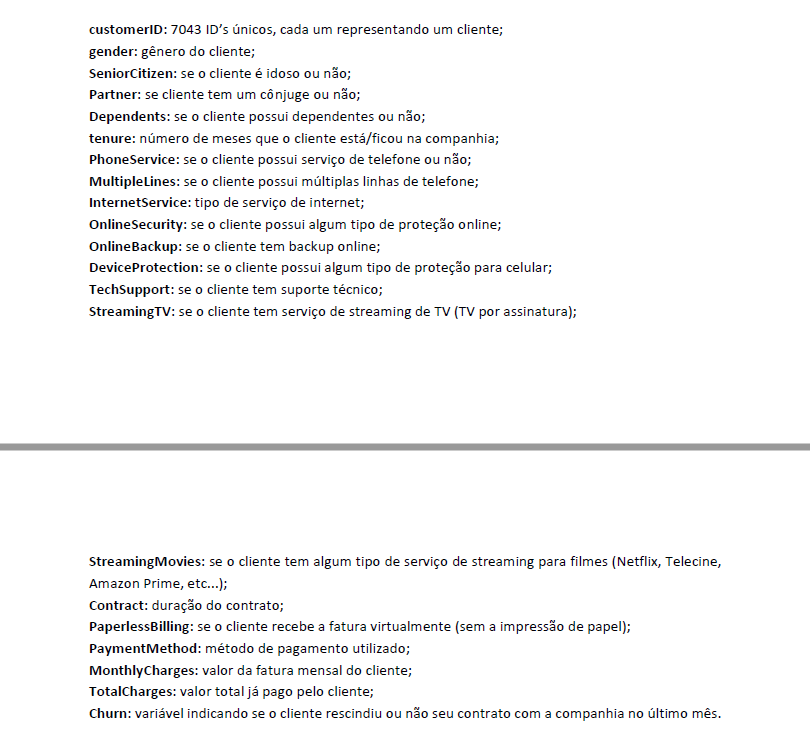

## Check NA

In [6]:
df_raw.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

- Apesar do output acima indicar não indicar a presença de missing values, identificamos que a coluna TotalCharges possuem algumas valores faltantes

In [7]:
valores_faltantes = df_raw.query('TotalCharges == " "').shape[0]
porcent_faltante = np.round(valores_faltantes / df_raw.shape[0]*100, 2)
print(f'{valores_faltantes} observações com valores faltantes, o que corresponde a {porcent_faltante}% de toda a base.')
df_raw.query('TotalCharges == " "')

11 observações com valores faltantes, o que corresponde a 0.16% de toda a base.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


- Como a porcentagem de valores faltantes é muito baixo, resolveremos excluir essas observações do DataFrame

In [8]:
df_1 = df_raw.copy()

df_1 = df_1.query('TotalCharges != " "')

## Change Data Types

In [9]:
df_1['TotalCharges'] = df_1['TotalCharges'].astype(float)

# Description Statistics

In [10]:
num_attributes = df_1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df_1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## Numerical Atributes

In [11]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,SeniorCitizen,0.00,1.00,1.0,0.162400,0.000,0.368818,1.831103,1.353321
1,tenure,1.00,72.00,71.0,32.421786,29.000,24.543514,0.237731,-1.387823
2,MonthlyCharges,18.25,118.75,100.5,64.798208,70.350,30.083835,-0.222103,-1.256156
3,TotalCharges,18.80,8684.80,8666.0,2283.300441,1397.475,2266.610181,0.961642,-0.231799


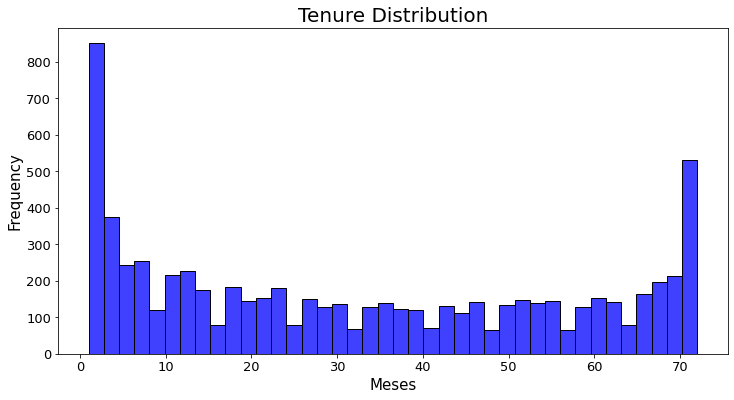

In [12]:
plt.figure(figsize=(12,6))
sns.histplot(
    x='tenure',
    data = df_1,

    kde=False,
    bins=40, color='blue')
plt.title('Tenure Distribution', fontsize=20)
plt.xlabel('Meses', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

- Percebemos que temos muitos clientes que estão no começo do contrato, assim como também existe um número significativo de clientes que estão com mais de 70 meses sob contrato

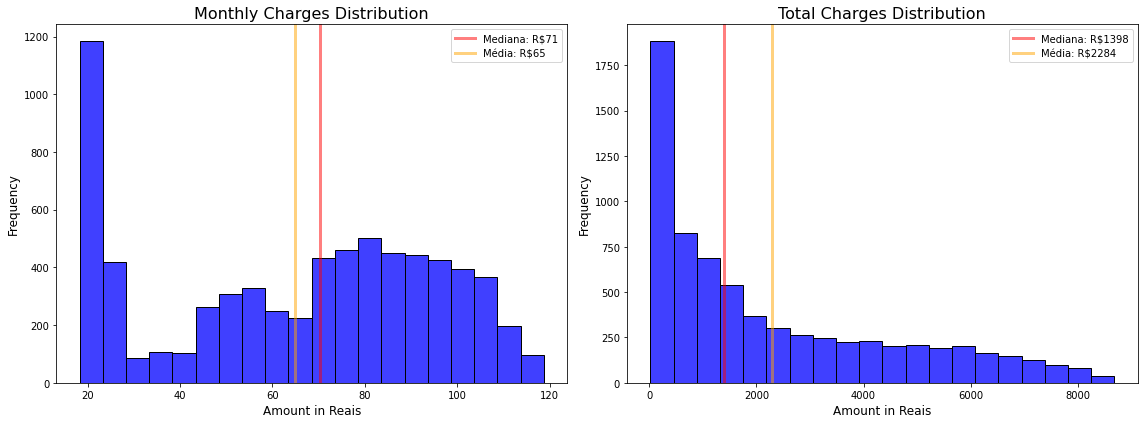

In [13]:
# Definir os dados e estatísticas de interesse
x_median_monthly = df_1.MonthlyCharges.median()
x_mean_monthly = df_1.MonthlyCharges.mean()
x_median_total = df_1.TotalCharges.median()
x_mean_total = df_1.TotalCharges.mean()

# Criar a figura e os subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Monthly Charges Distribution
sns.histplot(
    x='MonthlyCharges',
    data=df_1,
    kde=False,
    bins=20,
    color='blue',
    ax=axes[0]
)
axes[0].axvline(x=x_median_monthly, linewidth=3, color='red', label=f"Mediana: R${math.ceil(x_median_monthly)}",
                alpha=0.5)
axes[0].axvline(x=x_mean_monthly, linewidth=3, color='orange', label=f"Média: R${math.ceil(x_mean_monthly)}",
                alpha=0.5)
axes[0].set_title('Monthly Charges Distribution', fontsize=16)
axes[0].set_xlabel('Amount in Reais', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend(loc='best', facecolor='white')

# Plot 2: Total Charges Distribution
sns.histplot(
    x='TotalCharges',
    data=df_1,
    kde=False,
    bins=20,
    color='blue',
    ax=axes[1]
)
axes[1].axvline(x=x_median_total, linewidth=3, color='red', label=f"Mediana: R${math.ceil(x_median_total)}",
                alpha=0.5)
axes[1].axvline(x=x_mean_total, linewidth=3, color='orange', label=f"Média: R${math.ceil(x_mean_total)}",
                alpha=0.5)
axes[1].set_title('Total Charges Distribution', fontsize=16)
axes[1].set_xlabel('Amount in Reais', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(loc='best', facecolor='white')

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir o subplot
plt.show()

## Categorical Atributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

customerID          7032
gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
Churn                  2
dtype: int64

# Hyphotesis

## Target Variable

In [15]:
df_1.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

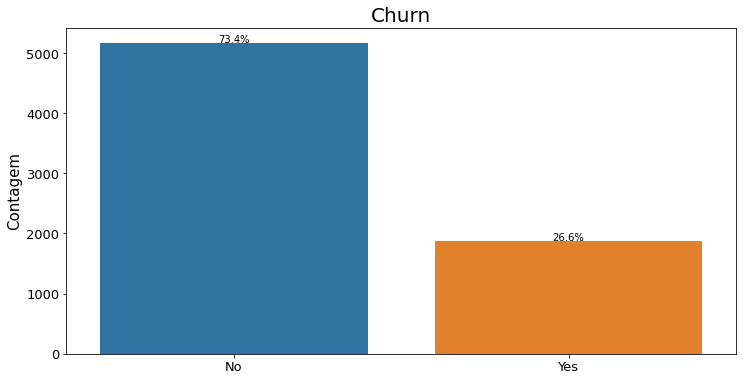

In [16]:
plt.figure(figsize=(12,6))


counts = df_1.Churn.value_counts()

ax = sns.barplot(x=counts.index, y=counts.values)

for i, v in enumerate(counts.values):
    ax.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

plt.title('Churn', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

26,6 % dos clientes cancelaram a assinatura

## Qual é o impacto do gênero no cancelamento?

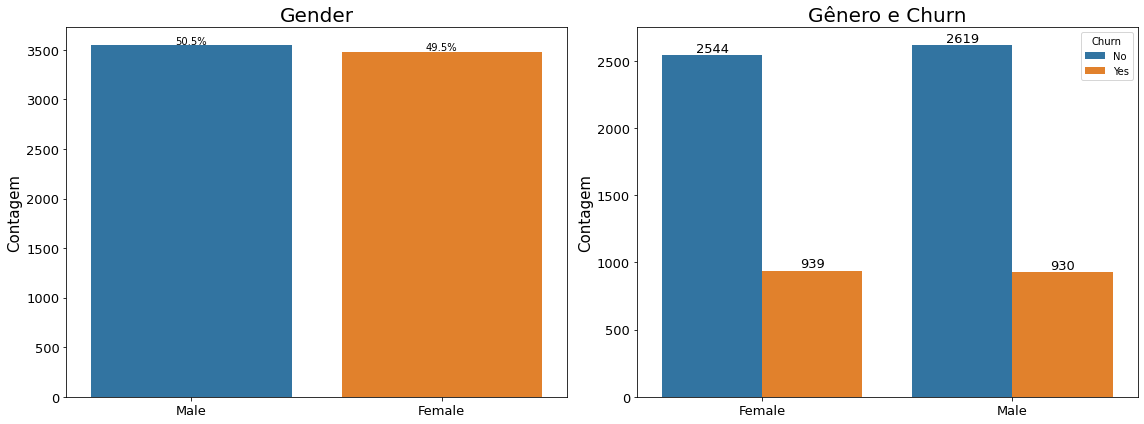

In [17]:
# Criar a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1 - Barplot com porcentagem em cima de cada barra
counts = df_1.gender.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax1)

for i, v in enumerate(counts.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

ax1.set_title('Gender', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Gráfico 2 - Countplot com valores em cima de cada barra
sns.countplot('gender', data=df_1, hue="Churn", ax=ax2)

ax2.set_title('Gênero e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Ajustar o layout dos subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

- O número de homens e mulheres na base é praticamente igual.
- De acordo com o gráfico acima, percebe-se que o gênero não impacta tanto no churn

## Qual o impacto da Idade no churn?

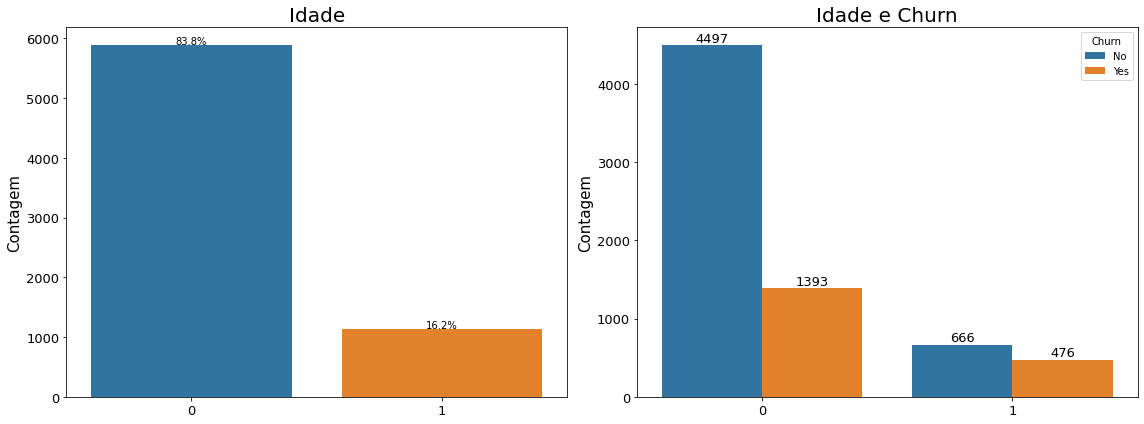

In [18]:
# Criar a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1 - Barplot com porcentagem em cima de cada barra
counts = df_1.SeniorCitizen.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax1)

for i, v in enumerate(counts.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

ax1.set_title('Idade', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Gráfico 2 - Countplot com valores em cima de cada barra
sns.countplot('SeniorCitizen', data=df_1, hue="Churn", ax=ax2)

ax2.set_title('Idade e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Ajustar o layout dos subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

In [19]:
df_1.groupby('SeniorCitizen').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,,,,,,,,
0,5890.0,2181.089550,2233.217848,18.80,365.575,1295.775,3566.3625,8684.8
1,1142.0,2810.465193,2364.314180,19.45,689.575,2263.750,4600.3125,8443.7


- Os clientes idosos representam apenas 16% do total de clientes, mas possuem uma taxa de cancelamento muito maior: 42% em comparação com 23% para os clientes não idosos. Os idosos gastam em média 29% na assinatura do que os clientes não idosos.

## Qual o impacto se o cliente tem um cônjuge?

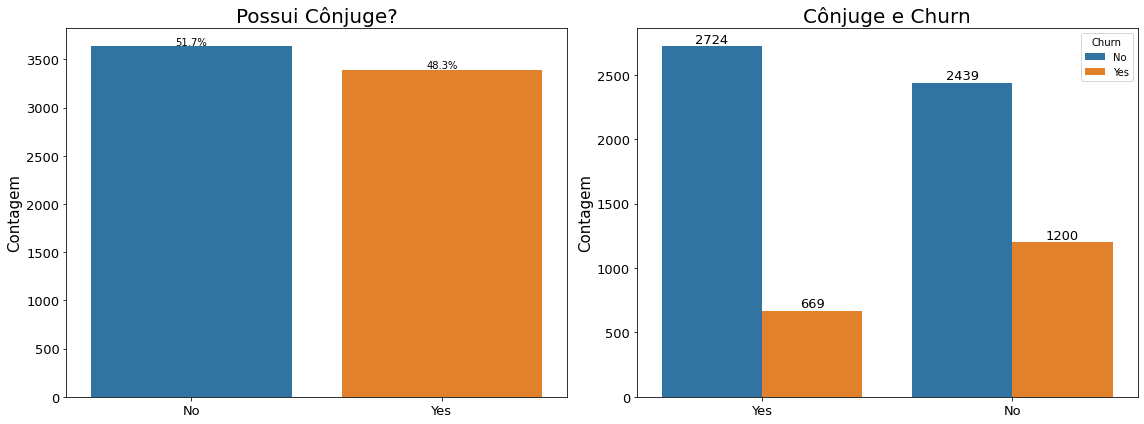

In [20]:
# Criar a figura e os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1 - Barplot com porcentagem em cima de cada barra
counts = df_1.Partner.value_counts()
sns.barplot(x=counts.index, y=counts.values, ax=ax1)

for i, v in enumerate(counts.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

ax1.set_title('Possui Cônjuge?', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Gráfico 2 - Countplot com valores em cima de cada barra
sns.countplot('Partner', data=df_1, hue="Churn", ax=ax2)

ax2.set_title('Cônjuge e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Ajustar o layout dos subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

- Os clientes solteiros tem maior propensão a cancelar o serviço

In [21]:
df_1.groupby('Partner').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
Partner,,,,,,,,
No,3639.0,1584.960429,1874.788687,18.85,191.20,811.8,2337.3,8547.15
Yes,3393.0,3032.271648,2407.614842,18.80,929.45,2347.9,5000.2,8684.80


## Qual o impacto de dependentes

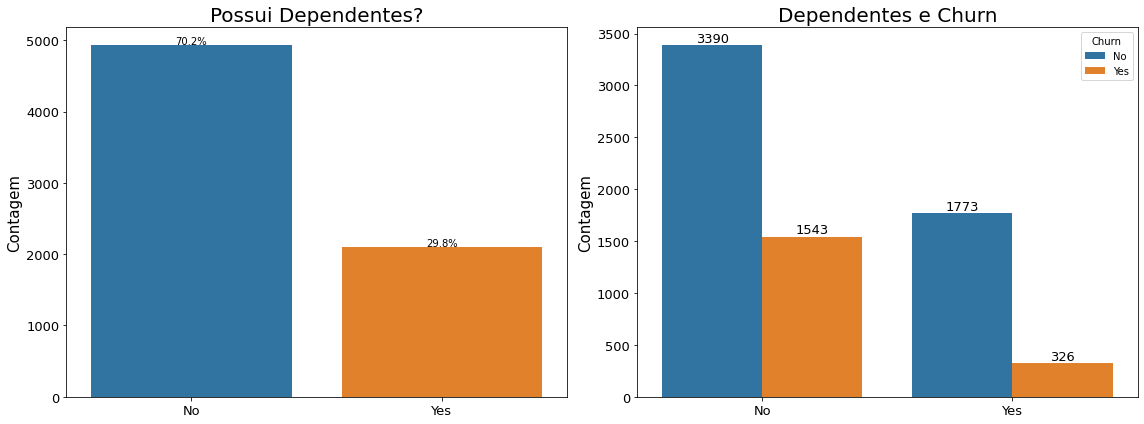

In [22]:
# Criação da figura e dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1 - Barplot para "Possui Dependentes?"
counts_dependents = df_1.Dependents.value_counts()
sns.barplot(x=counts_dependents.index, y=counts_dependents.values, ax=ax1)

for i, v in enumerate(counts_dependents.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

ax1.set_title('Possui Dependentes?', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Gráfico 2 - Countplot para "Dependentes e Churn"
sns.countplot('Dependents', data=df_1, hue="Churn", ax=ax2)

ax2.set_title('Dependentes e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)

# Mostrar valor em cima de cada barra no countplot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Ajustar o layout dos subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

- Os clientes que não possuem dependentes são mais propensos a cancelarem o serviço.

In [23]:
df_1.groupby('Dependents').TotalCharges.describe()

,count,mean,std,min,25%,50%,75%,max
Dependents,,,,,,,,
No,4933.0,2187.709254,2241.593582,18.85,323.250,1322.55,3581.400,8684.80
Yes,2099.0,2507.955669,2309.884010,18.80,596.275,1551.60,4161.325,8672.45


## Qual o impacto do  PhoneService e MultipleLines?

In [24]:
df_1.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


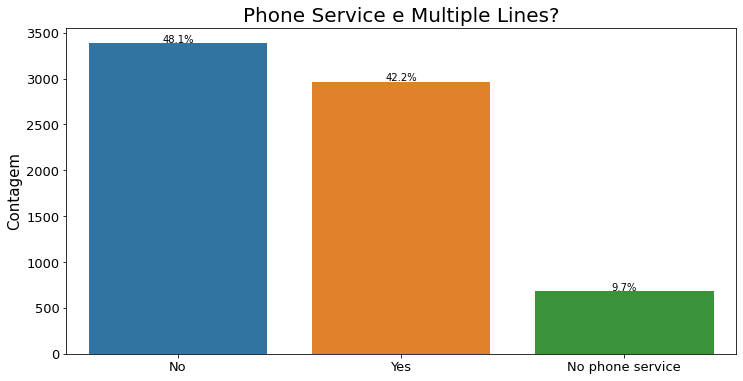

In [25]:
plt.figure(figsize=(12,6))


counts = df_1.MultipleLines.value_counts()

ax = sns.barplot(x=counts.index, y=counts.values)

for i, v in enumerate(counts.values):
    ax.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

plt.title('Phone Service e Multiple Lines?', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


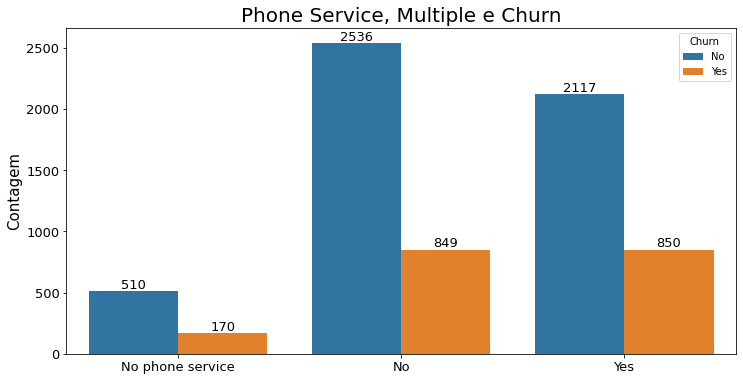

In [26]:
plt.figure(figsize=(12,6))
sns.countplot('MultipleLines', data=df_1, hue="Churn")

plt.title('Phone Service, Multiple e Churn', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Mostrar valor em cima de cada barra
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.show()

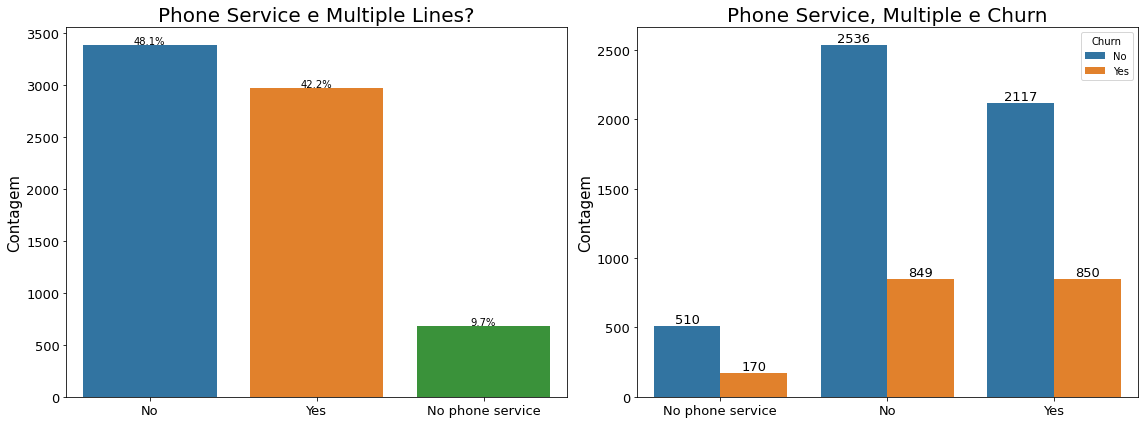

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primeiro gráfico
counts = df_1.MultipleLines.value_counts()
ax1 = sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
for i, v in enumerate(counts.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')
ax1.set_title('Phone Service e Multiple Lines?', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

# Segundo gráfico
ax2 = sns.countplot('MultipleLines', data=df_1, hue="Churn", ax=axes[1])
ax2.set_title('Phone Service, Multiple e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- Apesar da maioria dos clientes possuirem phone service, não há muita diferença entre a taxa de cancelamento entre as pessoas que possuem (26%) a as pessoas que não possuem o serviço de telefone (25%). E o fato do cliente ter mais de 1 linha de telefone também não tem um impacto relevante em comparação com os clientes que possuem somente 1 linha.

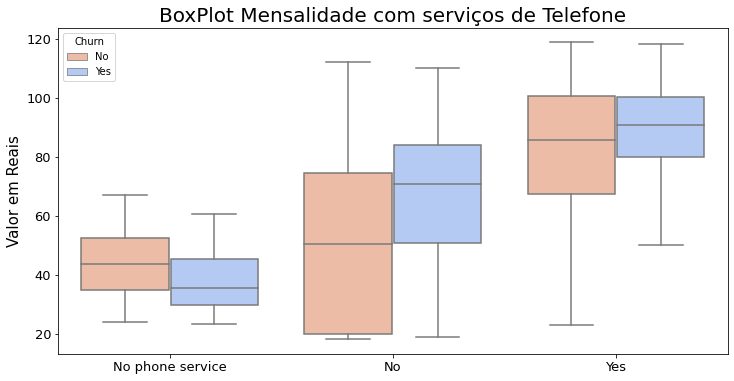

In [28]:

plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_1,
    x='MultipleLines',
    y='MonthlyCharges',showfliers=False,
palette='coolwarm_r', hue = 'Churn')

plt.title(f'BoxPlot Mensalidade com serviços de Telefone', fontsize=20)
plt.xlabel('',fontsize=15)
plt.ylabel('Valor em Reais', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

## Qual o impacto dos serviços de internet?

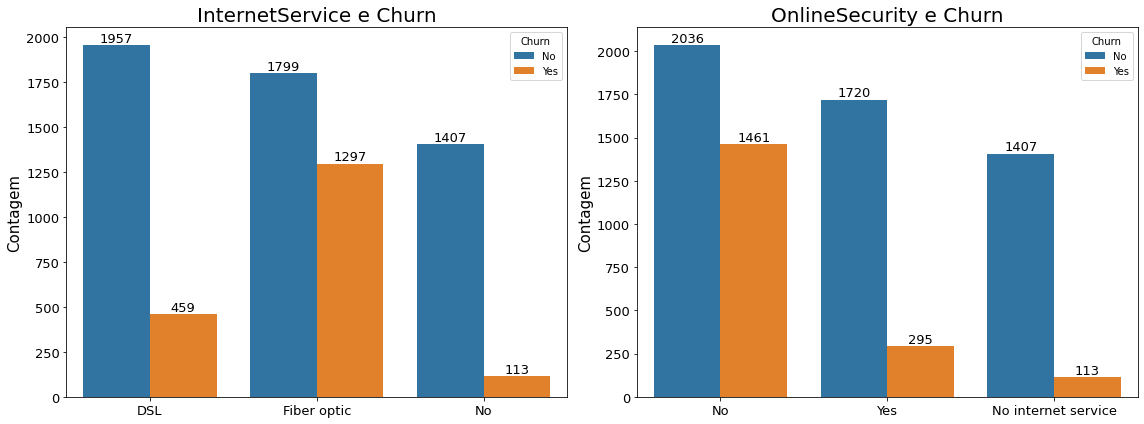

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primeiro gráfico
ax1 = sns.countplot('InternetService', data=df_1, hue="Churn", ax=axes[0])
ax1.set_title('InternetService e Churn', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Segundo gráfico
ax2 = sns.countplot('OnlineSecurity', data=df_1, hue="Churn", ax=axes[1])
ax2.set_title('OnlineSecurity e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- De acordo com o gráfico acima, percebe-se que há uma alta taxa de cancelamento entre os clientes que utilizam fibra ótica, o que sugere que os clientes estão insatisfeitos com esse serviço.

- Em relação a segurança online, percebe-se que os clientes que não possuem esse serviço tem uma alta taxa de cancelamento.

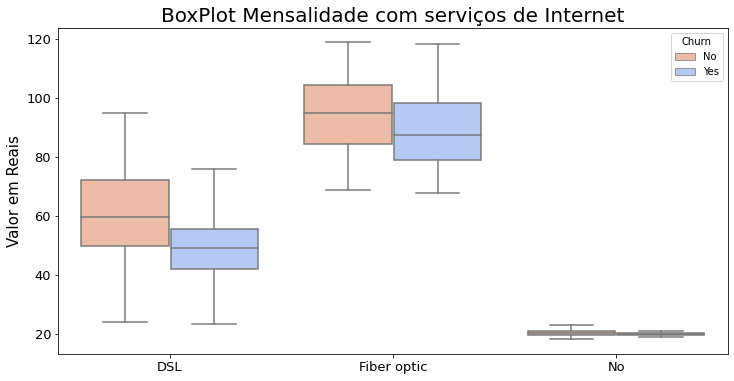

In [30]:

plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_1,
    x='InternetService',
    y='MonthlyCharges',showfliers=False,
palette='coolwarm_r', hue = 'Churn')

plt.title(f'BoxPlot Mensalidade com serviços de Internet', fontsize=20)
plt.xlabel('',fontsize=15)
plt.ylabel('Valor em Reais', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

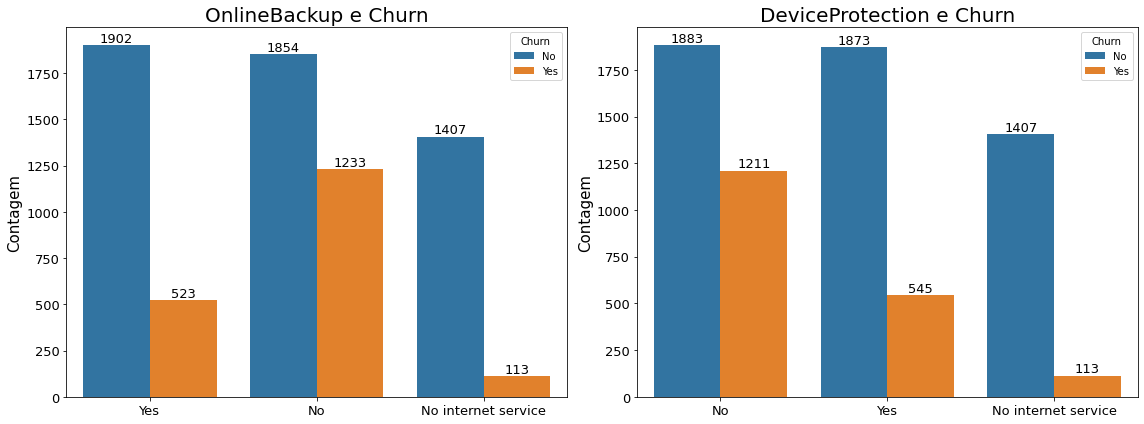

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primeiro gráfico
ax1 = sns.countplot('OnlineBackup', data=df_1, hue="Churn", ax=axes[0])
ax1.set_title('OnlineBackup e Churn', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Segundo gráfico
ax2 = sns.countplot('DeviceProtection', data=df_1, hue="Churn", ax=axes[1])
ax2.set_title('DeviceProtection e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- Os clientes que não possuem OnlineBackup e DeviceProtection tem uma alta taxa de cancelamento.

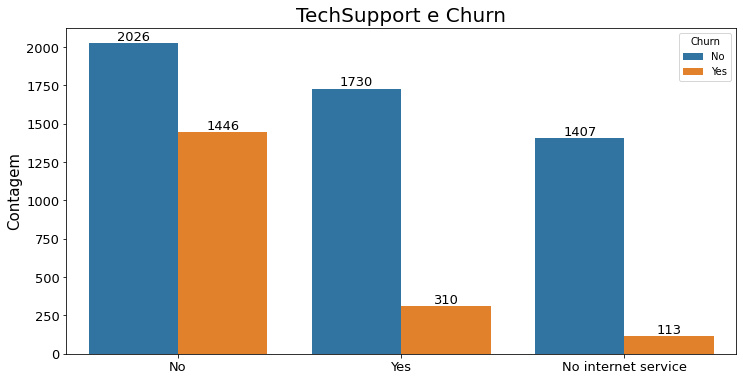

In [32]:
plt.figure(figsize=(12,6))
sns.countplot('TechSupport', data=df_1, hue="Churn")

plt.title('TechSupport e Churn', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Mostrar valor em cima de cada barra
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.show()

- Os clientes que não possuem TechSuport tem uma alta taxa de cancelamento. Melhorar o atendimento

## Qual o impacto do Streaming

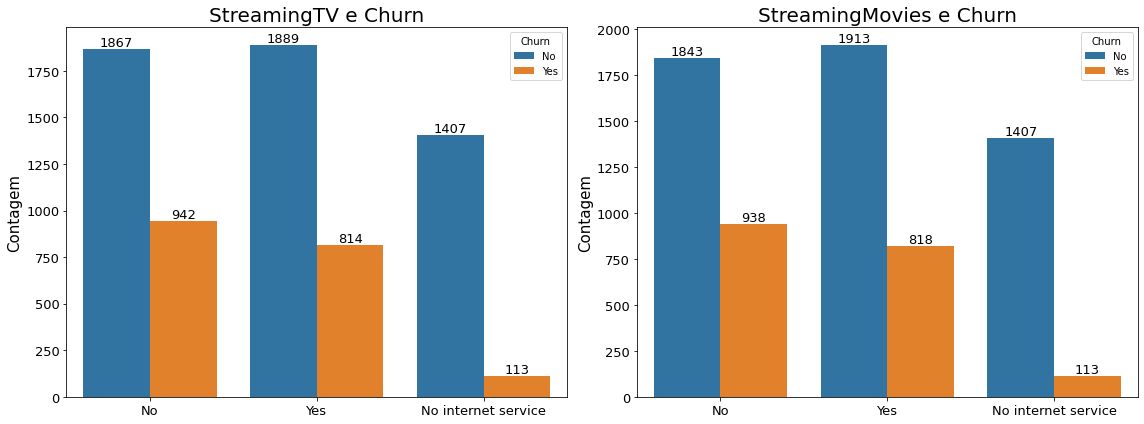

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primeiro gráfico
sns.countplot('StreamingTV', data=df_1, hue="Churn", ax=axes[0])
axes[0].set_title('StreamingTV e Churn', fontsize=20)
axes[0].set_ylabel('Contagem', fontsize=15)
axes[0].set_xlabel('', fontsize=15)
axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

# Segundo gráfico
sns.countplot('StreamingMovies', data=df_1, hue="Churn", ax=axes[1])
axes[1].set_title('StreamingMovies e Churn', fontsize=20)
axes[1].set_ylabel('Contagem', fontsize=15)
axes[1].set_xlabel('', fontsize=15)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- A inclusão de streaming na assinatura não é muito impactante no cancelamento

## Qual o impacto do tipo de contrato

In [34]:
df_1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


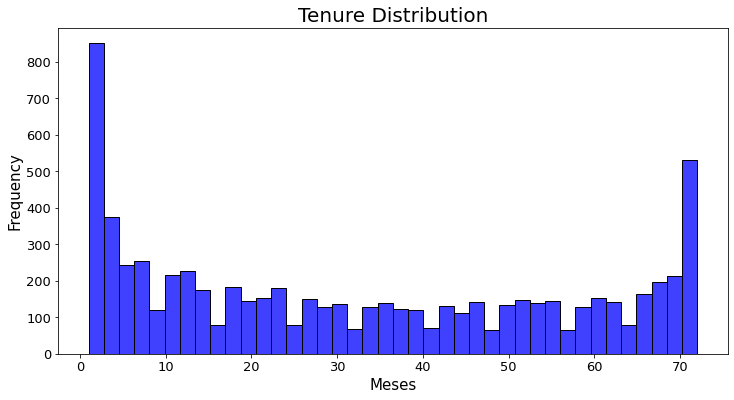

In [35]:
plt.figure(figsize=(12,6))
sns.histplot(
    x='tenure',
    data = df_1,

    kde=False,
    bins=40, color='blue')
plt.title('Tenure Distribution', fontsize=20)
plt.xlabel('Meses', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

- Percebemos que temos muitos clientes que estão no começo do contrato, assim como também existe um número significativo de clientes que estão com mais de 70 meses sob contrato

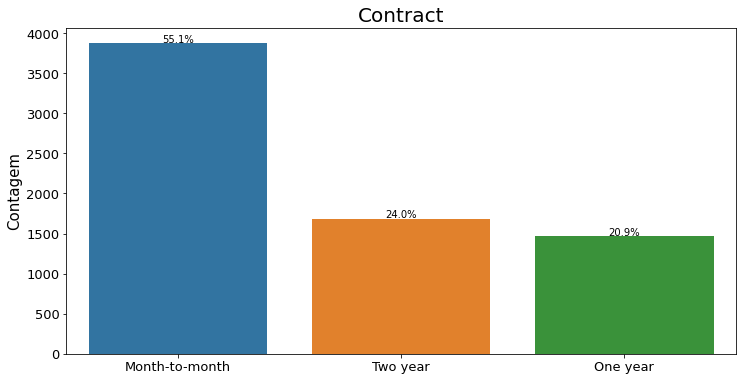

In [36]:
plt.figure(figsize=(12,6))


counts = df_1.Contract.value_counts()

ax = sns.barplot(x=counts.index, y=counts.values)

for i, v in enumerate(counts.values):
    ax.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

plt.title('Contract', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


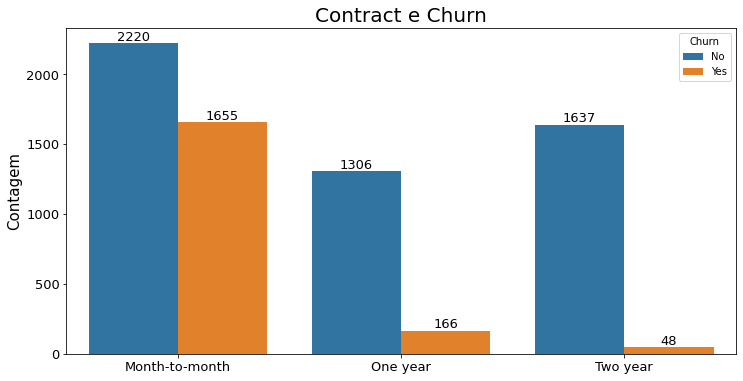

In [37]:
plt.figure(figsize=(12,6))
sns.countplot('Contract', data=df_1, hue="Churn")

plt.title('Contract e Churn', fontsize=20)
plt.ylabel('Contagem', fontsize=15)
plt.xlabel('', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Mostrar valor em cima de cada barra
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.show()

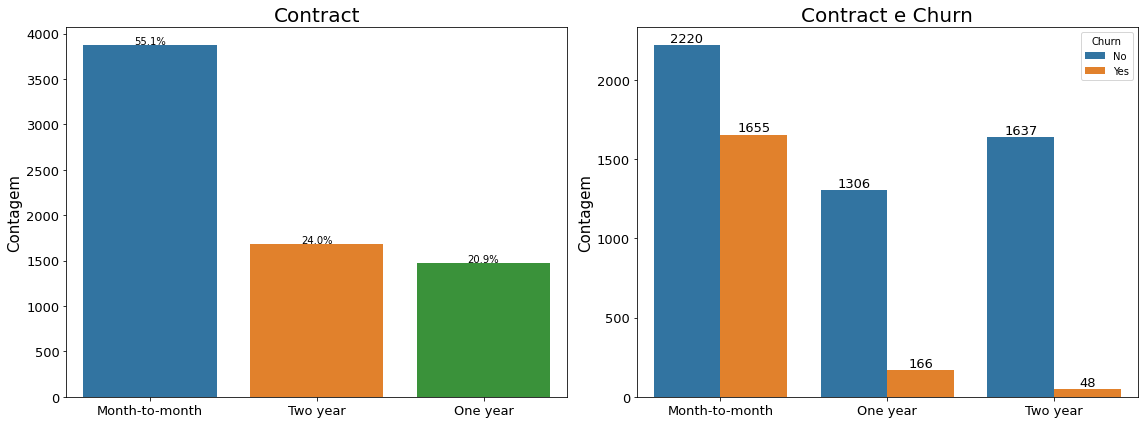

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primeiro gráfico
counts = df_1.Contract.value_counts()
ax1 = sns.barplot(x=counts.index, y=counts.values, ax=axes[0])
ax1.set_title('Contract', fontsize=20)
ax1.set_ylabel('Contagem', fontsize=15)
ax1.set_xlabel('', fontsize=15)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
for i, v in enumerate(counts.values):
    ax1.text(i, v + 10, "{:.1f}%".format((v/len(df_1))*100), ha='center')

# Segundo gráfico
ax2 = sns.countplot('Contract', data=df_1, hue="Churn", ax=axes[1])
ax2.set_title('Contract e Churn', fontsize=20)
ax2.set_ylabel('Contagem', fontsize=15)
ax2.set_xlabel('', fontsize=15)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- Mais da metade dos contratos são mês a mês, e estes são responsáveis pela grande maioria das assinaturas canceladas.

In [39]:
df_month = df_1.query('Contract == "Month-to-month"')

df_month.tenure.describe()

count    3875.000000
mean       18.036645
std        17.689054
min         1.000000
25%         3.000000
50%        12.000000
75%        29.000000
max        72.000000
Name: tenure, dtype: float64

In [40]:
df_one_year = df_1.query('Contract == "One year"')

df_one_year.tenure.describe()

count    1472.00000
mean       42.07337
std        19.01075
min         1.00000
25%        27.00000
50%        44.00000
75%        58.00000
max        72.00000
Name: tenure, dtype: float64

In [41]:
df_two_year = df_1.query('Contract == "Two year"')

df_two_year.tenure.describe()

count    1685.00000
mean       57.07181
std        17.72913
min         1.00000
25%        48.00000
50%        64.00000
75%        71.00000
max        72.00000
Name: tenure, dtype: float64

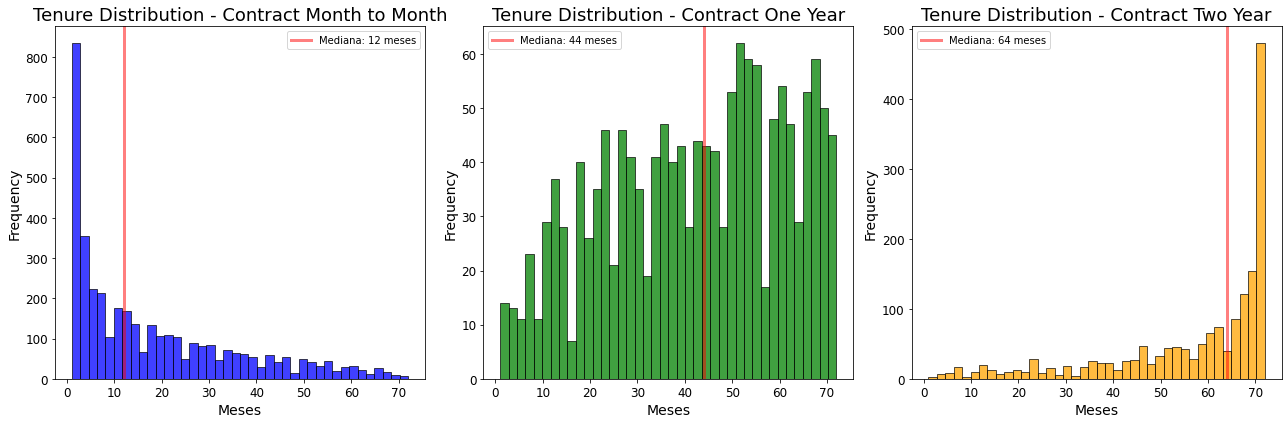

In [42]:
# Configuração dos dados e das medianas
data = [df_month, df_one_year, df_two_year]
titles = ['Contract Month to Month', 'Contract One Year', 'Contract Two Year']
colors = ['blue', 'green', 'orange']
medians = [df_month.tenure.median(), df_one_year.tenure.median(), df_two_year.tenure.median()]

# Criação do subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop para traçar cada histograma
for i, df in enumerate(data):
    ax = axes[i]
    
    sns.histplot(x='tenure', data=df, kde=False, bins=40, color=colors[i], ax=ax)
    ax.axvline(x=medians[i], linewidth=3, color='red', label=f"Mediana: {math.ceil(medians[i])} meses", alpha=0.5)
    
    ax.set_title(f'Tenure Distribution - {titles[i]}', fontsize=18)
    ax.set_xlabel('Meses', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.legend(loc='best', facecolor='white')

plt.tight_layout()
plt.show()

- É importante perceber que metade dos contratos mês a mês duram até 12 meses. Enquanto que os contratos mais longos (um ano e 2 anos), costumam durar mais tempo. Isso mostra que os clientes que optam por contratos mais longos são mais leais à empresa e tendem a permanecer por um período maior de tempo.

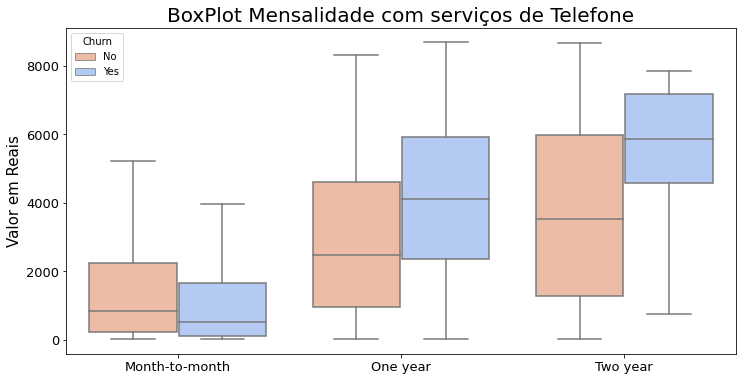

In [43]:

plt.figure(figsize=(12,6))

sns.boxplot(
    data=df_1,
    x='Contract',
    y='TotalCharges',showfliers=False,
palette='coolwarm_r', hue = 'Churn')

plt.title(f'BoxPlot Mensalidade com serviços de Telefone', fontsize=20)
plt.xlabel('',fontsize=15)
plt.ylabel('Valor em Reais', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13);

## Qual o impacto da forma de pagamento?

In [44]:
df_1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


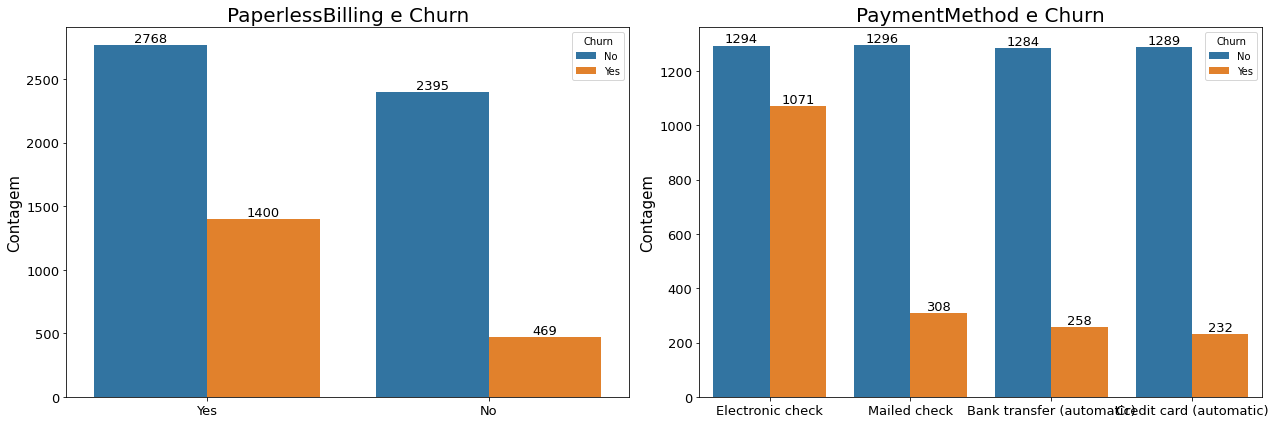

In [45]:
# Criação do subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1 - PaperlessBilling e Churn
sns.countplot('PaperlessBilling', data=df_1, hue="Churn", ax=axes[0])
axes[0].set_title('PaperlessBilling e Churn', fontsize=20)
axes[0].set_ylabel('Contagem', fontsize=15)
axes[0].set_xlabel('', fontsize=15)
axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)

for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=13)

# Gráfico 2 - PaymentMethod e Churn
sns.countplot('PaymentMethod', data=df_1, hue="Churn", ax=axes[1])
axes[1].set_title('PaymentMethod e Churn', fontsize=20)
axes[1].set_ylabel('Contagem', fontsize=15)
axes[1].set_xlabel('', fontsize=15)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)

for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

- Os clientes que tem PaperlessBilling tem maior propensão a churn.
- Os clientes que utilizam o Electronic Check tem maior propensão a churn

# Modelling

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from category_encoders import TargetEncoder, OneHotEncoder

from skopt import gp_minimize

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

In [48]:
df_2 = df_1.copy()
df_2.drop('customerID', axis = 1, inplace = True)

In [49]:
df_2['Churn'] = df_2.Churn.map({'No':0,
                       'Yes':1})

In [50]:
X = df_2.drop('Churn', axis = 1)
y = df_2["Churn"]

In [51]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [52]:
# Copiando os datasets originais
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [53]:
# Separando as features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

categorical_features = ['gender','Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

In [57]:
# Calculando rácio
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

2.7377746279234585

## Benchmarking Model

In [73]:
# Beanchmarking
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_transformer = Pipeline(steps = [
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Average Precision: {average_precision_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
y_pred_proba = pipeline.predict_proba(X_test)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba[:,1]):.2%}")

Accuracy: 79.58%
Average Precision: 45.50%
Precision Score: 62.86%
Recall Score: 52.84%
F1 Score: 57.41%
ROC AUC Score: 83.04%


Percebemos que o Modelo teve uma acurácia relativamente boa, no entanto, como os dados são desbalanceados, a acurácia não é a métrica ideal para avaliarmos o modelo. Ao avaliar o recall, observamos que nosso modelo acertou 58.84% dos casos em que os clientes realmente deram churn. Porém ao avaliar a precision, nosso modelo identificou corretamente apenas 62.86% dos casos em que previu que seria churn.

Iremos calcular o retorno financeiro do modelo caso estivesse em produção. Para isso, trabalharemos a seguinte promoção: 

**"Ganhe um desconto de 25% na sua recarga mensal nos próximos 6 meses!"**


Vamos considerar que essa promoção consiga reter os clientes que dariam churn por mais 6 meses.

Dessa forma, vamos calcular quanto estamos ganhando com a permanência dos clientes que dariam churn e quanto estamos deixando de ganhar aplicando a promoção para pessoas que não dariam churn, mas que o nosso modelo previu que dariam.

Para prosseguir, precisamos selecionar o dataframe que contém as pessoas que nosso modelo previu que dariam churn.

In [80]:
# Dataset com Previsão = Churn e Real = Churn
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] == y_pred]
indexes_1 = intersec[intersec == 1].index
X_test_copy_1 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_1, :]
X_test_copy_1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00
11,Male,0,Yes,No,8,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.00,632.95
16,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.55,93.55
18,Male,0,No,Yes,22,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,89.40,2001.50
28,Male,0,No,No,6,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.90,469.80


In [82]:
# Dataset com Previsão = Não Churn e Real = Churn 
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_2 = intersec[intersec == 0].index
X_test_copy_2 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_2, :]
X_test_copy_2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
19,Male,0,Yes,No,65,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),91.85,5940.85
29,Female,0,Yes,Yes,13,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,55.95,734.35
32,Male,0,Yes,Yes,39,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),80.00,3182.95
47,Male,0,Yes,Yes,32,Yes,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.55,3204.65
58,Male,0,Yes,Yes,49,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.80,4872.45


In [84]:
# Dataset com Previsão = Churn e Real = Não churn
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_3 = intersec[intersec == 1].index
X_test_copy_3 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_3, :]
X_test_copy_3.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7,Female,1,No,No,15,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.50,1400.3
10,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Electronic check,86.05,308.1
15,Male,0,No,No,22,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,93.20,2157.3
22,Male,0,No,No,5,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,51.35,262.3
23,Male,1,Yes,No,46,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.85,4564.9


In [89]:
# Valor recebido com a permanência
valor_recebido = (X_test_copy_1["MonthlyCharges"].values*0.75*6).sum()
print(f"O valor total recebido com a permanência dos clientes que dariam churn será: R$ {valor_recebido:.2f}")

# Valor perdido com a saída do cliente
valor_perdido = (X_test_copy_2["MonthlyCharges"].values*0.75*6).sum()
print(f"O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ {valor_perdido:.2f}")

# Valor deixado de ganhar com a oferta da promoção ao cliente que não daria churn
valor_deixado = (X_test_copy_2["MonthlyCharges"].values*0.25*6).sum()
print(f"O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ {valor_deixado:.2f}")

resultado_financeiro = valor_recebido - valor_perdido - valor_deixado

if resultado_financeiro >= 0:
    print(f"O lucro estimado será: R$ {resultado_financeiro:.2f}")
    
else:
    print(f"O prejuizo estimado será: R$ {resultado_financeiro:.2f}")



O valor total recebido com a permanência dos clientes que dariam churn será: R$ 87964.88
O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ 63448.43
O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ 21149.47
O lucro estimado será: R$ 3366.97


Com esse modelo em produção, teríamos um lucro estimado de **R$3.336,97**. Agora estimaremos os modelos ajustando o class_weight para verificar o impacto desse ajuste financeiramente. 

## Models with Class Weight

In [90]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [96]:
models = [
    ('LogisticRegression', LogisticRegression(class_weight = weights_dict)), 
    ('RandomForest', RandomForestClassifier(n_estimators = 1000, max_depth = 7, random_state = 0,
                                            n_jobs = -1, class_weight = weights_dict)),
    ('XGBoost', XGBClassifier(n_estimators=1000, max_depth=5, random_state=0,
                                                       scale_pos_weight=ratio, eval_metric='error'))

]

results = []

for model_name, model in models:
    print(model_name)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    cat_transformer = Pipeline(steps = [
        ('encoder', TargetEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', cat_transformer, categorical_features),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    result = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Average Precision': average_precision_score(y_test, y_pred),
        'Precision Score': precision_score(y_test, y_pred),
        'Recall Score': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC Score': roc_auc_score(y_test, y_pred_proba[:,1])
    }

    results.append(result)

results_df = pd.DataFrame(results)

LogisticRegression
RandomForest
XGBoost


Como o Catboost possui suas próprias opões de enconding, iremos utilizar o enconding do próprio Catboost.

In [97]:
model_cat = CatBoostClassifier(cat_features = categorical_features, scale_pos_weight = ratio)

In [98]:
model_cat.fit(X_train, y_train)

y_pred = model_cat.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

data = {
    'Model': ['Catboost'],
    'Accuracy': [accuracy],
    'Average Precision': [average_precision],
    'Precision Score': [precision],
    'Recall Score': [recall],
    'F1 Score': [f1],
    'ROC AUC Score': [roc_auc]
}

df_cat_metrics = pd.DataFrame(data)

Learning rate set to 0.020955
0:	learn: 0.6835559	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6737482	total: 18.6ms	remaining: 9.26s
2:	learn: 0.6654316	total: 28ms	remaining: 9.3s
3:	learn: 0.6580866	total: 34.3ms	remaining: 8.55s
4:	learn: 0.6509299	total: 41.7ms	remaining: 8.3s
5:	learn: 0.6441985	total: 46.6ms	remaining: 7.72s
6:	learn: 0.6365719	total: 54.7ms	remaining: 7.76s
7:	learn: 0.6290186	total: 64.3ms	remaining: 7.97s
8:	learn: 0.6225358	total: 69.2ms	remaining: 7.62s
9:	learn: 0.6159182	total: 81.3ms	remaining: 8.04s
10:	learn: 0.6104654	total: 88.3ms	remaining: 7.94s
11:	learn: 0.6041515	total: 93.5ms	remaining: 7.7s
12:	learn: 0.6011854	total: 96ms	remaining: 7.29s
13:	learn: 0.5959613	total: 101ms	remaining: 7.12s
14:	learn: 0.5908199	total: 106ms	remaining: 6.97s
15:	learn: 0.5861828	total: 111ms	remaining: 6.84s
16:	learn: 0.5816570	total: 117ms	remaining: 6.74s
17:	learn: 0.5770376	total: 121ms	remaining: 6.62s
18:	learn: 0.5727129	total: 126ms	remaining: 6.51s
19:	l

204:	learn: 0.4520796	total: 991ms	remaining: 3.84s
205:	learn: 0.4519590	total: 996ms	remaining: 3.84s
206:	learn: 0.4516436	total: 1s	remaining: 3.84s
207:	learn: 0.4513677	total: 1.01s	remaining: 3.84s
208:	learn: 0.4513046	total: 1.01s	remaining: 3.84s
209:	learn: 0.4512831	total: 1.02s	remaining: 3.83s
210:	learn: 0.4511026	total: 1.02s	remaining: 3.83s
211:	learn: 0.4510966	total: 1.02s	remaining: 3.81s
212:	learn: 0.4510966	total: 1.03s	remaining: 3.79s
213:	learn: 0.4508674	total: 1.03s	remaining: 3.79s
214:	learn: 0.4505878	total: 1.04s	remaining: 3.79s
215:	learn: 0.4503752	total: 1.04s	remaining: 3.78s
216:	learn: 0.4503391	total: 1.05s	remaining: 3.78s
217:	learn: 0.4503302	total: 1.05s	remaining: 3.77s
218:	learn: 0.4501759	total: 1.05s	remaining: 3.76s
219:	learn: 0.4499166	total: 1.06s	remaining: 3.76s
220:	learn: 0.4498396	total: 1.06s	remaining: 3.75s
221:	learn: 0.4495530	total: 1.07s	remaining: 3.75s
222:	learn: 0.4494492	total: 1.07s	remaining: 3.74s
223:	learn: 0.4

371:	learn: 0.4354367	total: 1.79s	remaining: 3.03s
372:	learn: 0.4351774	total: 1.8s	remaining: 3.02s
373:	learn: 0.4351163	total: 1.8s	remaining: 3.02s
374:	learn: 0.4348900	total: 1.81s	remaining: 3.02s
375:	learn: 0.4347977	total: 1.81s	remaining: 3.01s
376:	learn: 0.4347427	total: 1.82s	remaining: 3.01s
377:	learn: 0.4346085	total: 1.82s	remaining: 3s
378:	learn: 0.4344372	total: 1.83s	remaining: 3s
379:	learn: 0.4343854	total: 1.84s	remaining: 3s
380:	learn: 0.4342539	total: 1.84s	remaining: 2.99s
381:	learn: 0.4340079	total: 1.85s	remaining: 2.99s
382:	learn: 0.4338607	total: 1.85s	remaining: 2.98s
383:	learn: 0.4337529	total: 1.86s	remaining: 2.98s
384:	learn: 0.4337021	total: 1.86s	remaining: 2.98s
385:	learn: 0.4336795	total: 1.87s	remaining: 2.97s
386:	learn: 0.4335116	total: 1.87s	remaining: 2.97s
387:	learn: 0.4333478	total: 1.88s	remaining: 2.96s
388:	learn: 0.4333259	total: 1.88s	remaining: 2.96s
389:	learn: 0.4331717	total: 1.89s	remaining: 2.95s
390:	learn: 0.4329385	t

549:	learn: 0.4119244	total: 2.79s	remaining: 2.29s
550:	learn: 0.4118084	total: 2.8s	remaining: 2.28s
551:	learn: 0.4116955	total: 2.81s	remaining: 2.28s
552:	learn: 0.4114755	total: 2.81s	remaining: 2.27s
553:	learn: 0.4112502	total: 2.82s	remaining: 2.27s
554:	learn: 0.4111728	total: 2.83s	remaining: 2.27s
555:	learn: 0.4110780	total: 2.83s	remaining: 2.26s
556:	learn: 0.4109962	total: 2.84s	remaining: 2.25s
557:	learn: 0.4108248	total: 2.84s	remaining: 2.25s
558:	learn: 0.4107600	total: 2.85s	remaining: 2.25s
559:	learn: 0.4105473	total: 2.85s	remaining: 2.24s
560:	learn: 0.4104081	total: 2.86s	remaining: 2.24s
561:	learn: 0.4102742	total: 2.87s	remaining: 2.23s
562:	learn: 0.4100958	total: 2.87s	remaining: 2.23s
563:	learn: 0.4099144	total: 2.88s	remaining: 2.22s
564:	learn: 0.4097169	total: 2.88s	remaining: 2.22s
565:	learn: 0.4095353	total: 2.89s	remaining: 2.21s
566:	learn: 0.4093458	total: 2.89s	remaining: 2.21s
567:	learn: 0.4092207	total: 2.9s	remaining: 2.21s
568:	learn: 0.

726:	learn: 0.3906937	total: 3.8s	remaining: 1.43s
727:	learn: 0.3906147	total: 3.8s	remaining: 1.42s
728:	learn: 0.3904553	total: 3.81s	remaining: 1.42s
729:	learn: 0.3901939	total: 3.81s	remaining: 1.41s
730:	learn: 0.3900269	total: 3.82s	remaining: 1.41s
731:	learn: 0.3900097	total: 3.82s	remaining: 1.4s
732:	learn: 0.3899350	total: 3.83s	remaining: 1.4s
733:	learn: 0.3897590	total: 3.83s	remaining: 1.39s
734:	learn: 0.3897083	total: 3.84s	remaining: 1.38s
735:	learn: 0.3894644	total: 3.84s	remaining: 1.38s
736:	learn: 0.3893087	total: 3.85s	remaining: 1.37s
737:	learn: 0.3892058	total: 3.86s	remaining: 1.37s
738:	learn: 0.3890816	total: 3.86s	remaining: 1.36s
739:	learn: 0.3888907	total: 3.87s	remaining: 1.36s
740:	learn: 0.3888091	total: 3.87s	remaining: 1.35s
741:	learn: 0.3886945	total: 3.88s	remaining: 1.35s
742:	learn: 0.3886116	total: 3.89s	remaining: 1.34s
743:	learn: 0.3885186	total: 3.89s	remaining: 1.34s
744:	learn: 0.3884271	total: 3.9s	remaining: 1.33s
745:	learn: 0.388

902:	learn: 0.3726709	total: 4.8s	remaining: 516ms
903:	learn: 0.3725711	total: 4.81s	remaining: 511ms
904:	learn: 0.3724252	total: 4.82s	remaining: 505ms
905:	learn: 0.3723440	total: 4.82s	remaining: 500ms
906:	learn: 0.3722692	total: 4.83s	remaining: 495ms
907:	learn: 0.3722463	total: 4.83s	remaining: 490ms
908:	learn: 0.3721960	total: 4.84s	remaining: 484ms
909:	learn: 0.3721087	total: 4.84s	remaining: 479ms
910:	learn: 0.3720543	total: 4.85s	remaining: 474ms
911:	learn: 0.3719612	total: 4.86s	remaining: 469ms
912:	learn: 0.3718924	total: 4.86s	remaining: 463ms
913:	learn: 0.3717049	total: 4.87s	remaining: 458ms
914:	learn: 0.3716013	total: 4.87s	remaining: 453ms
915:	learn: 0.3715566	total: 4.88s	remaining: 447ms
916:	learn: 0.3714796	total: 4.88s	remaining: 442ms
917:	learn: 0.3713214	total: 4.89s	remaining: 437ms
918:	learn: 0.3711351	total: 4.9s	remaining: 432ms
919:	learn: 0.3710162	total: 4.91s	remaining: 427ms
920:	learn: 0.3709103	total: 4.91s	remaining: 422ms
921:	learn: 0.

In [94]:
df_cat_metrics

,Model,Accuracy,Average Precision,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,Catboost,0.751422,0.451172,0.515837,0.746725,0.610169,0.7883


In [99]:
results_df = pd.concat([results_df, df_cat_metrics], axis = 0)

results_df

,Model,Accuracy,Average Precision,Precision Score,Recall Score,F1 Score,ROC AUC Score
0,LogisticRegression,0.739477,0.448758,0.500000,0.786026,0.611205,0.830254
1,RandomForest,0.745165,0.445409,0.507396,0.748908,0.604938,0.833666
2,XGBoost,0.756542,0.411774,0.531120,0.558952,0.544681,0.784651
0,Catboost,0.751422,0.451172,0.515837,0.746725,0.610169,0.784651


Iremos escolher o modelo de Regressão Logística para fazer a otimização dos hiperparametros, pois foi o modelo que teve o maior Recall.

In [102]:
from skopt import gp_minimize
from skopt.space import Real, Categorical

# Função de treinamento do modelo
def treinar_modelo(params):
    c = params[0]
    penalty = params[1]
    solver = params[2]
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    cat_transformer = Pipeline(steps = [
        ('encoder', TargetEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', cat_transformer, categorical_features),
        ])

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(class_weight = weights_dict, C = c, penalty = penalty,
                                          solver = solver))
    ])

    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    return -roc_auc_score(y_test, y_pred)

# Criando o espaço de navegação dos hiperparâmetros
param_space = [
    Real(1e-6, 1e+6, prior='log-uniform', name='C'),  # Faixa de valores para o parâmetro de regularização C
    Categorical(['l1', 'l2'], name='penalty'),       # Tipo de regularização
    Categorical(['liblinear', 'saga'], name='solver') # Algoritmo de otimização
]                      

resultado = gp_minimize(treinar_modelo, param_space)

In [103]:
# Obtenha os melhores parâmetros da otimização
best_params = {
    'C': resultado.x[0],       # Valor de C otimizado
    'penalty': resultado.x[1],  # Tipo de regularização otimizado
    'solver': resultado.x[2]    # Algoritmo de otimização otimizado
}

In [104]:
# Com os melhores hiperparametros
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_transformer = Pipeline(steps = [
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features),
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight=weights_dict, **best_params))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                            

In [107]:
import joblib
# Nome do arquivo pkl onde o pipeline será salvo
pkl_filename = "pipeline_with_logistic_regression.pkl"

# Salve o pipeline em um arquivo pkl
joblib.dump(pipeline, pkl_filename)

['pipeline_with_logistic_regression.pkl']

In [ ]:
# Carregar o pipeline a partir do arquivo pkl
pkl_filename = "pipeline_with_logistic_regression.pkl"
loaded_pipeline = joblib.load(pkl_filename)

# Fazer previsões usando o pipeline carregado
y_pred_load = loaded_pipeline.predict(X_test)

In [108]:
y_pred = pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Average Precision: {average_precision_score(y_test, y_pred):.2%}")
print(f"Precision Score: {precision_score(y_test, y_pred):.2%}")
print(f"Recall Score: {recall_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2%}")
y_pred_proba = pipeline.predict_proba(X_test)
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba[:,1]):.2%}")

Accuracy: 74.46%
Average Precision: 45.58%
Precision Score: 50.63%
Recall Score: 79.48%
F1 Score: 61.85%
ROC AUC Score: 83.29%


Percebemos que houve uma melhora no Recall saindo de 78,6% para 79,48%. Agora iremos calcular os resultados financeiros desse novo modelo.

In [115]:
# Dataset com Previsão = Churn e Real = Churn
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] == y_pred]
indexes_1 = intersec[intersec == 1].index
X_test_copy_1 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_1, :]
X_test_copy_1.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00
11,Male,0,Yes,No,8,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,75.00,632.95
16,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,93.55,93.55
18,Male,0,No,Yes,22,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,89.40,2001.50
28,Male,0,No,No,6,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.90,469.80


In [112]:
# Dataset com Previsão = Não Churn e Real = Churn 
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_2 = intersec[intersec == 0].index
X_test_copy_2 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_2, :]
X_test_copy_2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
19,Male,0,Yes,No,65,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),91.85,5940.85
32,Male,0,Yes,Yes,39,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),80.00,3182.95
63,Female,1,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),92.45,6440.25
74,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.95,20.95
87,Female,0,Yes,Yes,41,Yes,No,DSL,No,Yes,No,Yes,No,Yes,One year,Yes,Bank transfer (automatic),66.50,2728.60


In [116]:
# Dataset com Previsão = Churn e Real = Não churn
y_pred = pd.Series(pipeline.predict(X_test))
intersec = y_pred[y_test.reset_index().drop(columns = 'index', axis = 1)["Churn"] != y_pred]
indexes_3 = intersec[intersec == 1].index
X_test_copy_3 = X_test_copy.reset_index().drop(columns = 'index', axis = 1).iloc[indexes_3, :]
X_test_copy_3.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4,Female,0,No,No,6,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),29.45,161.45
5,Male,0,Yes,No,3,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Credit card (automatic),29.80,94.40
7,Female,1,No,No,15,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.50,1400.30
10,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,No,Electronic check,86.05,308.10
15,Male,0,No,No,22,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Mailed check,93.20,2157.30


In [118]:
# Valor recebido com a permanência
valor_recebido = (X_test_copy_1["MonthlyCharges"].values*0.75*6).sum()
print(f"O valor total recebido com a permanência dos clientes que dariam churn será: R$ {valor_recebido:.2f}")

# Valor perdido com a saída do cliente
valor_perdido = (X_test_copy_2["MonthlyCharges"].values*0.75*6).sum()
print(f"O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ {valor_perdido:.2f}")

# Valor deixado de ganhar com a oferta da promoção ao cliente que não daria churn
valor_deixado = (X_test_copy_2["MonthlyCharges"].values*0.25*6).sum()
print(f"O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ {valor_deixado:.2f}")

resultado_financeiro = valor_recebido - valor_perdido - valor_deixado

if resultado_financeiro >= 0:
    print(f"O lucro estimado será: R$ {resultado_financeiro:.2f}")
    
else:
    print(f"O prejuizo estimado será: R$ {resultado_financeiro:.2f}")



O valor total recebido com a permanência dos clientes que dariam churn será: R$ 125245.80
O valor total perdido com a saída dos clientes que deram churn e nosso modelo não previu será: R$ 26167.50
O valor total deixado de ganhar com a oferta da promoção a clientes que não dariam churn será: R$ 8722.50
O lucro estimado será: R$ 90355.80


Com esse modelo em produção, teríamos um lucro estimado de **R$90.355,80**. Um lucro bem maior em comparação ao primeiro modelo. 

## Threshold

In [57]:
import joblib

In [310]:
# Nome do arquivo pkl onde o pipeline será salvo
pkl_filename = "pipeline_with_logistic_regression.pkl"

# Salve o pipeline em um arquivo pkl
joblib.dump(pipeline, pkl_filename)

['pipeline_with_logistic_regression.pkl']

In [58]:
# Carregar o pipeline a partir do arquivo pkl
pkl_filename = "pipeline_with_logistic_regression.pkl"
loaded_pipeline = joblib.load(pkl_filename)

# Fazer previsões usando o pipeline carregado
y_pred_load = loaded_pipeline.predict(X_test)

In [77]:
results_thres = []

for thres in np.arange(0.05, 1, 0.05):
    y_pred = (loaded_pipeline.predict_proba(X_test)[:,1]>thres)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    results_thres.append((thres, precision, recall, f1, acc))

In [80]:
results_thres_df = pd.DataFrame(results_thres, columns = ['thres', 'precision', 'recall', 'f1', 'acc'])

results_thres_df

,thres,precision,recall,f1,acc
0,0.05,0.310947,0.991435,0.473415,0.414107
1,0.10,0.343328,0.980728,0.508606,0.496587
2,0.15,0.365992,0.967880,0.531140,0.546075
3,0.20,0.384615,0.952891,0.548030,0.582480
4,0.25,0.401654,0.935760,0.562058,0.612628
5,0.30,0.422244,0.918630,0.578557,0.644482
6,0.35,0.439457,0.901499,0.590877,0.668373
7,0.40,0.457589,0.877944,0.601614,0.691126
8,0.45,0.483271,0.835118,0.612245,0.718999
9,0.50,0.506739,0.805139,0.622002,0.740046


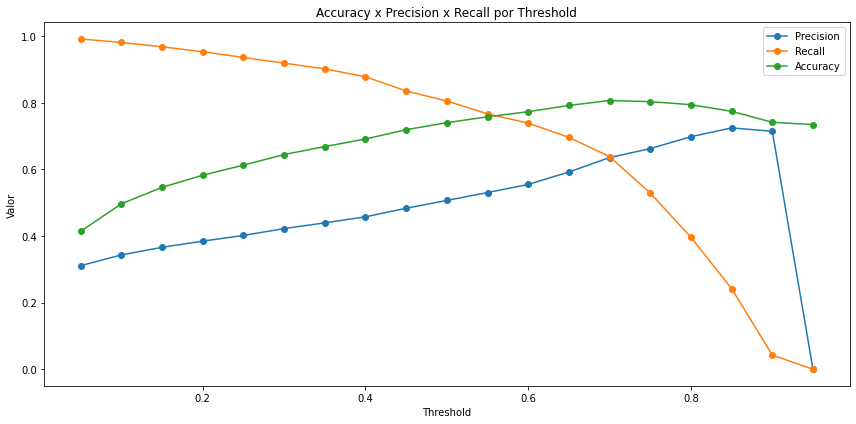

In [85]:
plt.figure(figsize = (12,6))

plt.plot(results_thres_df['thres'], results_thres_df['precision'], label = 'Precision', marker = 'o')
plt.plot(results_thres_df['thres'], results_thres_df['recall'], label = 'Recall', marker = 'o')
plt.plot(results_thres_df['thres'], results_thres_df['acc'], label = 'Accuracy', marker = 'o')
plt.title('Accuracy x Precision x Recall por Threshold')
plt.xlabel('Threshold')
plt.ylabel('Valor')
#plt.grid(True)
plt.tight_layout()
plt.legend();